In [1]:
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, GlobalAveragePooling2D, Activation,
    MaxPooling2D
)

# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from tf.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import BatchNormalization

# How to check if Keras is using GPU?

#from tf.keras import backend as K

#K.tensorflow_backend._get_available_gpus()

train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

In [2]:
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(train['digit'].values)

In [3]:
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_test = tf.keras.utils.to_categorical(train['digit'].values)

In [4]:
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [5]:
# Create the base model from the pre-trained model VGG16
model = Sequential()
model.add(Conv2D(32, kernel_size = (5,5), padding = 'Same',
                 activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(32, kernel_size = (5,5), padding = 'Same',
                 activation='relu'))
model.add(Conv2D(32, kernel_size = (5,5), padding = 'Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3,3),padding = 'Same',
                 activation='relu'))
model.add(Conv2D(64, kernel_size = (3,3),padding = 'Same',
                 activation='relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = 4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        3

In [7]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [8]:
print(X_train.shape)
print(y_train.shape)

(2048, 28, 28, 1)
(2048, 10)


In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [10]:
epochs = 20
batch_size = 86
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size = 0.1)

history = model.fit_generator(
    datagen.flow(X_train2, y_train2, batch_size=batch_size),
    epochs=epochs, 
    steps_per_epoch=1000,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer], 
    verbose=2
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1000/1000 - 39s - loss: 1.1286 - accuracy: 0.6178 - val_loss: 0.4728 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 2/20
1000/1000 - 14s - loss: 0.3551 - accuracy: 0.8813 - val_loss: 0.5429 - val_accuracy: 0.8244 - lr: 9.5000e-04
Epoch 3/20
1000/1000 - 14s - loss: 0.1956 - accuracy: 0.9354 - val_loss: 0.5447 - val_accuracy: 0.8683 - lr: 9.0250e-04
Epoch 4/20
1000/1000 - 15s - loss: 0.1309 - accuracy: 0.9568 - val_loss: 0.6986 - val_accuracy: 0.8439 - lr: 8.5737e-04
Epoch 5/20
1000/1000 - 15s - loss: 0.0944 - accuracy: 0.9694 - val_loss: 0.6587 - val_accuracy: 0.8634 - lr: 8.1451e-04
Epoch 6/20
1000/1000 - 15s - loss: 0.0784 - accuracy: 0.9744 - val_loss: 0.9031 - val_accuracy: 0.7951 - lr: 7.7378e-04
Epoch 7/20
1000/1000 - 14s - loss: 0.0619 - accuracy: 0.9797 - val_loss: 0.7702 - val_accuracy: 0.8488 - lr: 7.3509e-04
Epoch 8/20
1000/1000 - 15s - loss: 0.0559 - accuracy: 0.9820 - val_loss: 0.8338 - val_ac

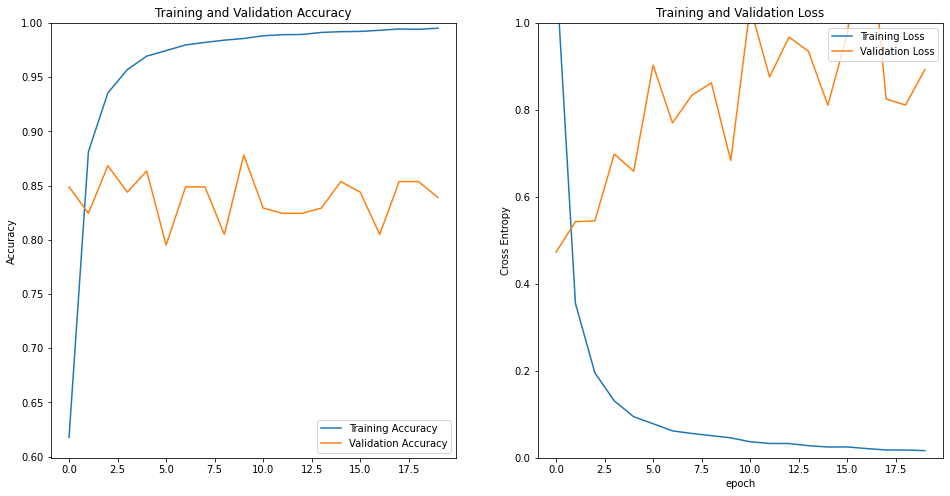

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"model.json", "w") as json_file : 
    json_file.write(model_json)

In [13]:
X_test.shape

(20480, 28, 28, 1)

In [14]:
result = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [15]:
result

array([6, 9, 8, ..., 6, 3, 0])

In [16]:
submission['digit'] = result

In [17]:
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


In [18]:
submission.to_csv('./data/submission.csv', index=False)